In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, kruskal
from math import sqrt

import wrangle
import explore

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# import df
df, train_exp, X_train_scaled, y_train, X_test_scaled, y_test = wrangle.wrangle_data()
df.shape, train_exp.shape, X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape

Acquire: compiling raw data files...
Acquire: Completed!
Prepare: preparing data files...
Prepare: Completed!
(289, 25) (73, 25)


((362, 26), (289, 26), (289, 22), (289, 1), (73, 22), (73, 1))

In [3]:
train_exp.shape

(289, 26)

In [4]:
df.shape

(362, 26)

In [5]:
train_exp.head()

,tract,raw_svi,f_pov_soci,f_unemp_soci,f_pci_soci,f_nohsdp_soci,f_soci_total,f_age65_comp,f_age17_comp,f_disabl_comp,...,f_mobile_trans,f_crowd_trans,f_noveh_trans,f_groupq_trans,f_trans_total,all_flags_total,zip,tract_cases_per_100k,bin_svi,rank_svi
289,48029181821,0.4879,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,78249,2627.300031,low_mod,3
200,48029171902,0.6394,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,78227,3860.722824,mod_high,2
69,48029130200,0.6523,0,0,0,0,0,0,0,0,...,0,0,1,0,1,2,78205,3784.707315,mod_high,2
29,48029121120,0.0872,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,78247,2222.089837,low,4
12,48029120502,0.9531,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,78218,3232.937228,high,1


<div class="alert alert-block alert-info"><b></b></div>

## Question One: Is there a correlation between the CDC's Range Category SVI Score and COVID-19 Infection Cases per 100k Individuals?

In [6]:
def sns_boxplot(train_exp):
    '''create boxplot for exploration'''
    #axes1.margins(x=0.05)
    plt.figure(figsize=(12,8))
    plt.rc('font', size=16)
    sns.boxplot(data=train_exp, x='bin_svi', y='tract_cases_per_100k')
    plt.title('December 8th COVID-19 Cases per 100K by SVI Range Category')
    plt.xlabel("CDC's SVI Range Category",labelpad=20)
    plt.ylabel("COVID-19 Cases per 100K",labelpad=20)
    plt.tight_layout()
    plt.show()

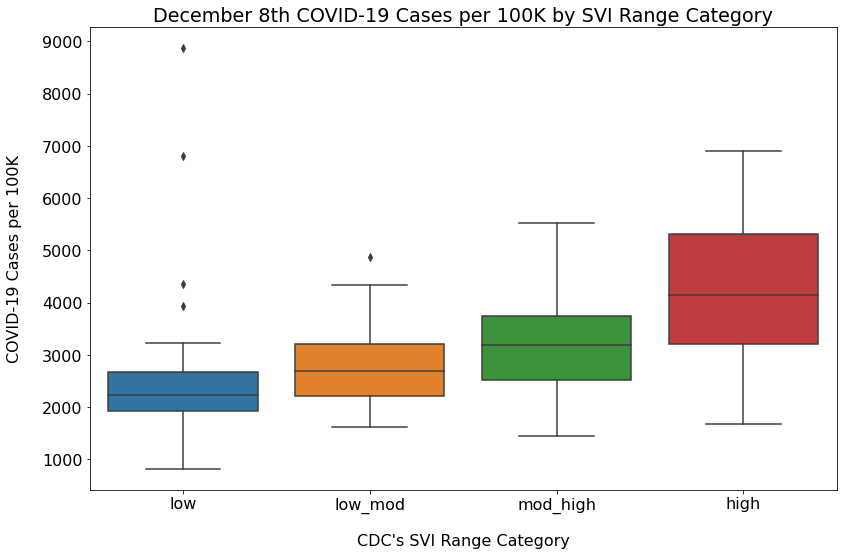

In [7]:
sns_boxplot(train_exp)

### Takeaway:
`There appears to be a correlation between COVID-19 Count and SVI Category. Next step is Hypothesis testing between categories to validate statistical significance`

In [8]:
# Mean COVID-19 Count By CDC's SVI Category
All = round(train_exp.tract_cases_per_100k.mean(),5)
low = round((train_exp[train_exp.bin_svi == 'low']).tract_cases_per_100k.mean(),5)
low_mod = round((train_exp[train_exp.bin_svi == 'low_mod']).tract_cases_per_100k.mean(),6)
mod_high = round((train_exp[train_exp.bin_svi == 'mod_high']).tract_cases_per_100k.mean(),6)
high = round((train_exp[train_exp.bin_svi== 'high']).tract_cases_per_100k.mean(),6)

print(f'The average number of cases per 100k for all CDC SVI Range Categories is {All}') 
print(f'The average number of cases per 100k for CDC SVI Range Category (low) is {low}')
print(f'The average number of cases per 100k for CDC SVI Range Category (low_mod) is {low_mod}')
print(f'The average number of cases per 100k for CDC SVI Range Category (mod_high) is {mod_high}')
print(f'The average number of cases per 100k for CDC SVI Range Category (high) is {high}')

The average number of cases per 100k for all CDC SVI Range Categories is 3201.96835
The average number of cases per 100k for CDC SVI Range Category (low) is 2419.21848
The average number of cases per 100k for CDC SVI Range Category (low_mod) is 2705.049127
The average number of cases per 100k for CDC SVI Range Category (mod_high) is 3180.716072
The average number of cases per 100k for CDC SVI Range Category (high) is 4164.339725



**Is This Difference Statistically Significant? (ANOVA/Kruskal)**

*Question - Is there a significant difference in average number of COVID-19 cases per 100k when examined by CDC SVI Range Category ?*

null = Average number of COVID-19 cases per 100k is the same across all CDC SVI Range Categories   


alternate = Average number of COVID-19 cases per 100k is significantly different counties across all CDC SVI Range Categories   


alpha = 0.01 (Let's be 99% certain the result we see aren't due to chance/randomness)   


In [9]:
# f_oneway is our ANOVA test
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html for more info

low = (train_exp[train_exp.bin_svi == 'low']).tract_cases_per_100k
low_mod = (train_exp[train_exp.bin_svi == 'low_mod']).tract_cases_per_100k
mod_high = (train_exp[train_exp.bin_svi == 'mod_high']).tract_cases_per_100k
high = (train_exp[train_exp.bin_svi== 'high']).tract_cases_per_100k

#### Variance Test

In [10]:
stats.levene(low, low_mod, mod_high, high)

LeveneResult(statistic=10.327163320383526, pvalue=1.7911798087531878e-06)

#### p-value < 0.05, Non Parametric Version of ANOVA (Kruskal)

In [11]:
alpha = 0.01
null = "Average number of COVID-19 cases per 100k is the same across all CDC SVI Range Categories "
alternate = "Average number of COVID-19 cases per 100k is significantly different counties across all CDC SVI Range Categories "

f, p = kruskal(low, low_mod, mod_high, high)
print('f=', f)
print('p=', p)
print('\n')
if p < alpha:
    print("We reject the null that: \n", null)
    print('\n')
    print("We move forward with the alternative hypothesis that: \n", alternate)
else:
    print("We fail to reject the null")
    print("Evidence does not support the claim that smoking status and time of day are dependent/related")

f= 101.26363037368904
p= 8.313345339410492e-22


We reject the null that: 
 Average number of COVID-19 cases per 100k is the same across all CDC SVI Range Categories 


We move forward with the alternative hypothesis that: 
 Average number of COVID-19 cases per 100k is significantly different counties across all CDC SVI Range Categories 


**Takeaway**

`We can state with 99% certainty that there is a statistically significant difference between all of the CDC SVI Range Categories`

<div class="alert alert-block alert-info"><b></b></div>

## Question Two: Is there a correlation between raw_svi and cases per 100k?

#### Pearsons R

In [12]:
# isolate variables to test
raw_svi = train_exp.raw_svi
cases_per_100k = train_exp.tract_cases_per_100k
null = "There is no statistically significant difference betweeen raw_svi and cases per 100K "
alternate = "There is a statistically significant difference betweeen raw_svi and cases per 100K"

In [13]:
def pearson(continuous_var1, continuous_var2, null, alternate):
    '''
    runs pearson r test on 2 continuous variables
    '''
    alpha = .01
    r, p = stats.pearsonr(continuous_var1, continuous_var2)
    print('r=', r)
    print('p=', p)
    print('\n')
    if p < alpha:
        print("We reject the null that: \n", null)
        print('\n')
        print("We move forward with the alternative hypothesis that: \n", alternate)
    else:
        print("We fail to reject the null")
        print("Evidence does not support the claim that smoking status and time of day are dependent/related")


In [14]:
pearson(raw_svi,cases_per_100k, null, alternate)

r= 0.5447686910162987
p= 9.797910801365502e-24


We reject the null that: 
 There is no statistically significant difference betweeen raw_svi and cases per 100K 


We move forward with the alternative hypothesis that: 
 There is a statistically significant difference betweeen raw_svi and cases per 100K


## explore.py Function

In [15]:
def sns_boxplot(train_exp):
    '''create boxplot for hypothesis test exploration
    '''
    #axes1.margins(x=0.05)
    plt.figure(figsize=(12,8))
    plt.rc('font', size=16)
    sns.boxplot(data=train_exp, x='bin_svi', y='tract_cases_per_100k')
    plt.title('December 8th COVID-19 Cases per 100K by SVI Range Category')
    plt.xlabel("CDC's SVI Range Category",labelpad=20)
    plt.ylabel("COVID-19 Cases per 100K",labelpad=20)
    plt.tight_layout()
    plt.show()
    
def kruskal_test(avg_var1, avg_var2, avg_var3, avg_var4, null, alternate, alpha):
    '''
    Runs non parametric ANOVA when p-value from levene test(variance) is < 0.05
    '''
    alpha = alpha
    f, p = kruskal(avg_var1,avg_var2,avg_var3,avg_var4)
    print('f=', f)
    print('p=', p)
    print('\n')
    if p < alpha:
        print("We reject the null that: \n", null)
        print('\n')
        print("We move forward with the alternative hypothesis that: \n", alternate)
    else:
        print("We fail to reject the null")
        print("Evidence does not support the claim that smoking status and time of day are dependent/related")
    
def pearson(continuous_var1, continuous_var2, null, alternate, alpha):
    '''
    runs pearson r test on 2 continuous variables
    '''
    alpha = alpha
    r, p = stats.pearsonr(continuous_var1, continuous_var2)
    print('r=', r)
    print('p=', p)
    print('\n')
    if p < alpha:
        print("We reject the null that: \n", null)
        print('\n')
        print("We move forward with the alternative hypothesis that: \n", alternate)
    else:
        print("We fail to reject the null")
        print("Evidence does not support the claim that smoking status and time of day are dependent/related")

#### Function Test

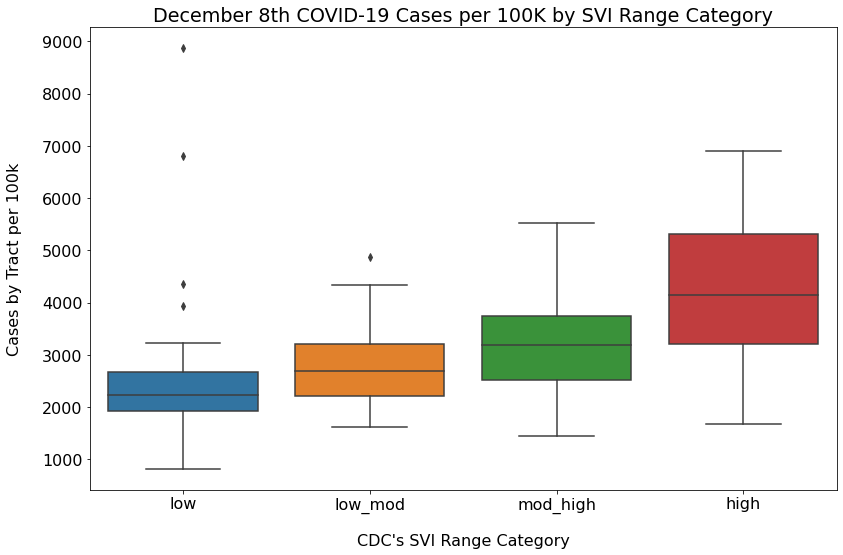

In [16]:
explore.sns_boxplot(train_exp)

In [17]:
low = (train_exp[train_exp.bin_svi == 'low']).tract_cases_per_100k
low_mod = (train_exp[train_exp.bin_svi == 'low_mod']).tract_cases_per_100k
mod_high = (train_exp[train_exp.bin_svi == 'mod_high']).tract_cases_per_100k
high = (train_exp[train_exp.bin_svi== 'high']).tract_cases_per_100k
alpha = 0.01
null = "Average number of COVID-19 cases per 100k is the same across all CDC SVI Range Categories "
alternate = "Average number of COVID-19 cases per 100k is significantly different across all CDC SVI Range Categories "
explore.kruskal_test(low, low_mod, mod_high, high, null, alternate, alpha)

f= 101.26363037368904
p= 8.313345339410492e-22


We reject the null that: 
 Average number of COVID-19 cases per 100k is the same across all CDC SVI Range Categories 


We move forward with the alternative hypothesis that: 
 Average number of COVID-19 cases per 100k is significantly different across all CDC SVI Range Categories 


In [18]:
raw_svi = train_exp.raw_svi
cases_per_100k = train_exp.tract_cases_per_100k
alpha = 0.01
null = "There is no statistically significant difference betweeen raw_svi and cases per 100K "
alternate = "There is a statistically significant difference betweeen raw_svi and cases per 100K"
explore.pearson(raw_svi, cases_per_100k, null, alternate, alpha)

r= 0.5447686910162987
p= 9.797910801365502e-24


We reject the null that: 
 There is no statistically significant difference betweeen raw_svi and cases per 100K 


We move forward with the alternative hypothesis that: 
 There is a statistically significant difference betweeen raw_svi and cases per 100K


#### Explore Graphing Functions:

In [19]:
def joint_plot_index(x,y,df,hue):
    """
    Function that produces a joint plot and examines data by categorical variable
    """
    ax = sns.jointplot(x = x, 
                       y = y, 
                       data = df, 
                       hue = hue, 
                       height = 10,
                       space = 0)
    ax.ax_joint.set_xlabel("SVI Index Value", fontweight='bold', fontsize = 14, labelpad=20)
    ax.ax_joint.set_ylabel('Cases by Tract per 100k', fontweight='bold', fontsize = 14, labelpad=20)
    ax.fig.suptitle("Distribution of Cases and SVI Score", fontweight='bold', fontsize = 20)    
    ax.fig.tight_layout()
    plt.show()

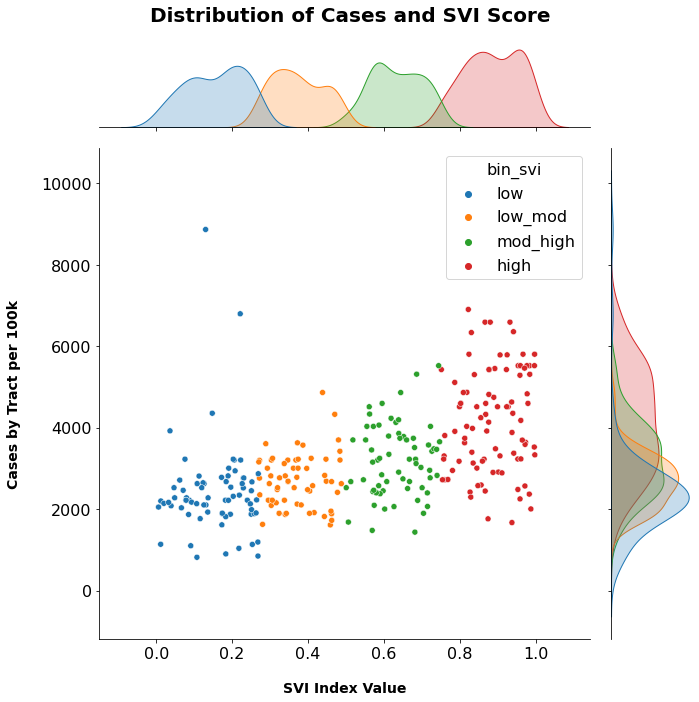

In [20]:
explore.joint_plot_index('raw_svi','tract_cases_per_100k', train_exp, 'bin_svi')

In [21]:
def joint_plot_flag(x,y,df,hue):
    ax2 = sns.jointplot(x = x, 
                        y = y, 
                        data = df, 
                        hue = hue, 
                        height = 10,
                        space = 0,
                        xlim =(-1,10),)
    ax2.ax_joint.set_xlabel('Total Number of Flags', fontweight='bold', fontsize = 14,labelpad=20)
    ax2.ax_joint.set_ylabel('Cases by Tract per 100k', fontweight='bold', fontsize = 14,labelpad=20)
    ax2.fig.suptitle("Distribution of Cases and SVI Flags", fontweight='bold', fontsize = 20)

    ax.fig.tight_layout()
    plt.show()


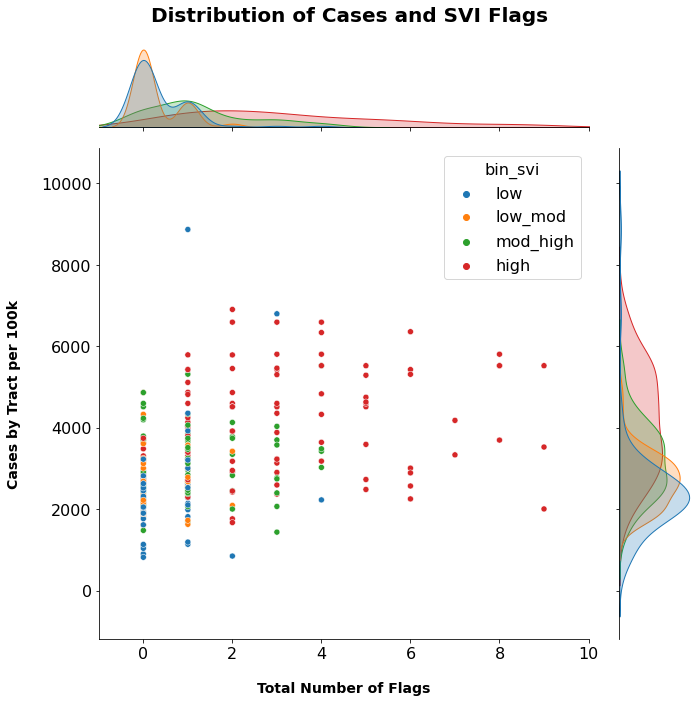

In [22]:
explore.joint_plot_flag("all_flags_total","tract_cases_per_100k",train_exp,'bin_svi')

In [23]:
# Creating the histograms
def hist_case(series):
    plt.figure(figsize=(12,8))
    plt.rc('font', size=16)
    plt.hist(x = series, bins = 10, color = 'gray', edgecolor='k', alpha=0.45)
    plt.title('Distribution of Cases in San Antonio, TX: December 8th 2020', y=1.02)
    plt.xlabel('Number of Cases per 100,000',labelpad=20)
    plt.ylabel('Case Count',labelpad=20)
    plt.axvline(series.mean(), color = 'tab:orange', linestyle='dashed', linewidth=5)
    min_ylim_v, max_ylim_v = plt.ylim()
    plt.text(series.mean()*1.05, max_ylim_v*0.9, 'Mean: {:.2f}'.format(series.mean()))
    plt.axvline(train_exp.tract_cases_per_100k.median(), color = 'darkgreen', linestyle='dashed', linewidth=5)
    plt.text(series.median()*.25, max_ylim_v*0.9, 'Median: {:.2f}'.format(series.median()))
    plt.grid(b = True, alpha = .45)
    # plt.figure(figsize = (16, 9))
    plt.tight_layout()
    plt.show()


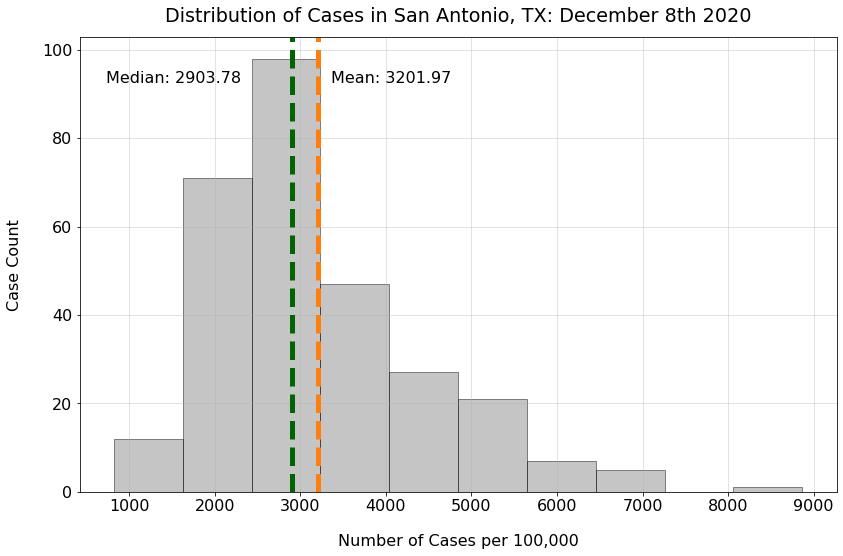

In [24]:
explore.hist_case(train_exp.tract_cases_per_100k)